<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/UTS/RegresiUTSTelkom/Regresi(MLP)_dan_Klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import gdown
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import models, layers, callbacks, regularizers, optimizers
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import LeakyReLU
import keras_tuner as kt

# Feature Engineering

In [4]:
file_id = '1iir3m4hP09fCeOyC-Igx4RwXkuVAMz6m'
output = 'RegresiUTSTelkom.csv'

# Unduh file dari Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}&confirm=t', output=output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1iir3m4hP09fCeOyC-Igx4RwXkuVAMz6m&confirm=t
To: /content/RegresiUTSTelkom.csv
100%|██████████| 443M/443M [00:07<00:00, 61.6MB/s]


'RegresiUTSTelkom.csv'

In [5]:
df = pd.read_csv(output)
df.columns = ['target'] + [f'feat_{i}' for i in range(1, df.shape[1])]
print("Nama kolom setelah direname:\n", df.columns.tolist()[:10])

Nama kolom setelah direname:
 ['target', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9']


In [6]:
print("\nInfo Dataset:")
print(df.info())
print("\nDeskripsi Statistik:")
print(df.describe().T)


Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515344 entries, 0 to 515343
Data columns (total 91 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   target   515344 non-null  int64  
 1   feat_1   515344 non-null  float64
 2   feat_2   515344 non-null  float64
 3   feat_3   515344 non-null  float64
 4   feat_4   515344 non-null  float64
 5   feat_5   515344 non-null  float64
 6   feat_6   515344 non-null  float64
 7   feat_7   515344 non-null  float64
 8   feat_8   515344 non-null  float64
 9   feat_9   515344 non-null  float64
 10  feat_10  515344 non-null  float64
 11  feat_11  515344 non-null  float64
 12  feat_12  515344 non-null  float64
 13  feat_13  515344 non-null  float64
 14  feat_14  515344 non-null  float64
 15  feat_15  515344 non-null  float64
 16  feat_16  515344 non-null  float64
 17  feat_17  515344 non-null  float64
 18  feat_18  515344 non-null  float64
 19  feat_19  515344 non-null  float64
 20  feat_20  51

In [7]:
print("Jumlah data duplikat:", int(df.duplicated().sum()))
df = df.drop_duplicates(keep='first')

Jumlah data duplikat: 214


In [8]:
print("Jumlah missing values per kolom:\n", df.isnull().sum())

Jumlah missing values per kolom:
 target     0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
          ..
feat_86    0
feat_87    0
feat_88    0
feat_89    0
feat_90    0
Length: 91, dtype: int64


In [9]:
X = df.drop(columns='target')
y = df['target']

var_selector = VarianceThreshold(threshold=0.0)
X_var_filtered = var_selector.fit_transform(X)

selected_features = X.columns[var_selector.get_support()]
print(f"\nJumlah fitur setelah filter varian: {len(selected_features)} dari {X.shape[1]}")


Jumlah fitur setelah filter varian: 90 dari 90


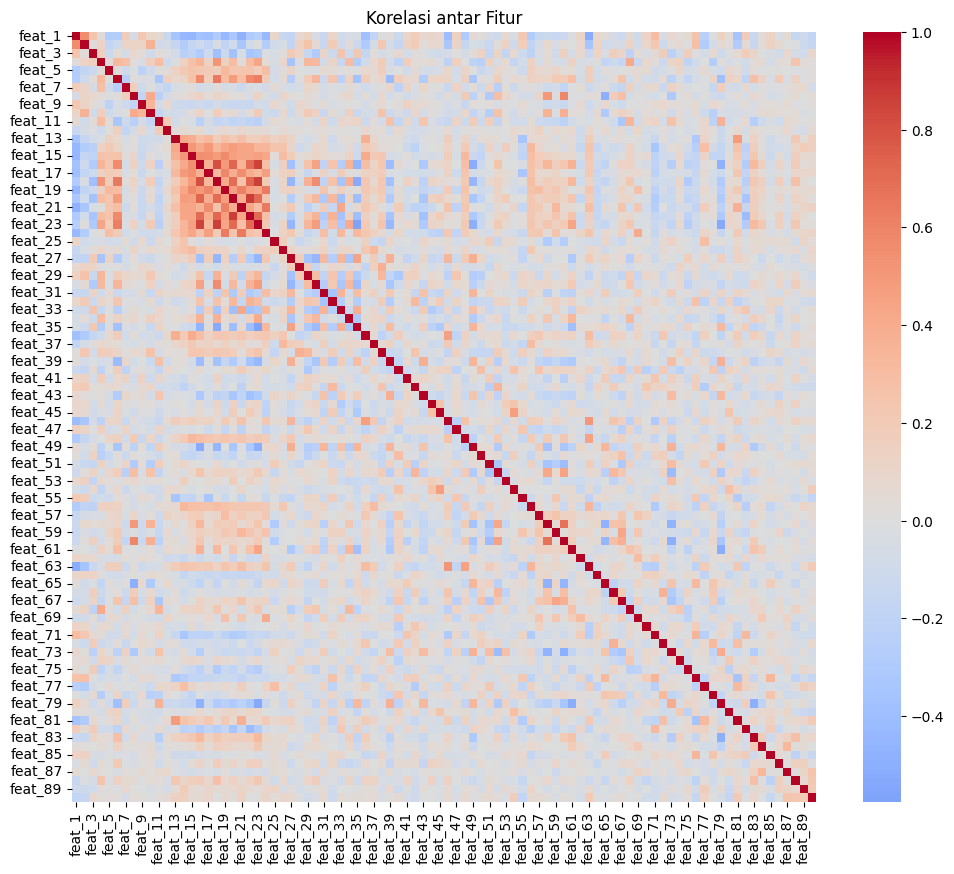


Top 10 fitur dengan korelasi tertinggi terhadap target:
feat_1     0.225345
feat_6    -0.187441
feat_3    -0.139575
feat_63   -0.126319
feat_40   -0.123996
feat_7     0.110461
feat_67   -0.102841
feat_46   -0.101340
feat_36   -0.101050
feat_69   -0.099486
dtype: float64


In [10]:
corr_matrix = df[selected_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Korelasi antar Fitur")
plt.show()

cor_with_target = df[selected_features].corrwith(df['target'])
cor_sorted = cor_with_target.sort_values(key=np.abs, ascending=False)

top_features = cor_sorted.head(10).index.tolist()
print("\nTop 10 fitur dengan korelasi tertinggi terhadap target:")
print(cor_sorted.head(10))

In [11]:
print("\nOutlier Berdasarkan IQR:")
for col in selected_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"{col}: {len(outliers)} outlier")


Outlier Berdasarkan IQR:
feat_1: 10620 outlier
feat_2: 14641 outlier
feat_3: 15626 outlier
feat_4: 22677 outlier
feat_5: 10454 outlier
feat_6: 11987 outlier
feat_7: 13902 outlier
feat_8: 14532 outlier
feat_9: 15393 outlier
feat_10: 6234 outlier
feat_11: 15795 outlier
feat_12: 13600 outlier
feat_13: 18665 outlier
feat_14: 26216 outlier
feat_15: 20560 outlier
feat_16: 24665 outlier
feat_17: 20035 outlier
feat_18: 21404 outlier
feat_19: 17744 outlier
feat_20: 25453 outlier
feat_21: 21140 outlier
feat_22: 19183 outlier
feat_23: 23799 outlier
feat_24: 20371 outlier
feat_25: 41976 outlier
feat_26: 40178 outlier
feat_27: 45578 outlier
feat_28: 38293 outlier
feat_29: 35697 outlier
feat_30: 32354 outlier
feat_31: 32658 outlier
feat_32: 36288 outlier
feat_33: 32742 outlier
feat_34: 36856 outlier
feat_35: 32965 outlier
feat_36: 31179 outlier
feat_37: 46174 outlier
feat_38: 34204 outlier
feat_39: 31256 outlier
feat_40: 33024 outlier
feat_41: 36633 outlier
feat_42: 32232 outlier
feat_43: 33130 out

In [12]:
df_cleaned = df.copy()
for col in selected_features:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

print(f"\nJumlah data setelah menghapus outlier: {df_cleaned.shape[0]} dari {df.shape[0]}")


Jumlah data setelah menghapus outlier: 40127 dari 515130


In [16]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

def create_preprocessing_pipeline(numeric_features, categorical_features):
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop'
    )
    return preprocessor

In [17]:
REG_TARGET = df_cleaned.columns[0]
df_cleaned['target_clf'] = (df_cleaned[REG_TARGET] > df_cleaned[REG_TARGET].median()).astype(int)
CLS_TARGET = 'target_clf'

features = [c for c in df_cleaned.columns if c not in [REG_TARGET, CLS_TARGET]]
numeric_feats = df_cleaned[features].select_dtypes(include=['int64','float64']).columns.tolist()
categorical_feats = df_cleaned[features].select_dtypes(include=['object','category']).columns.tolist()
preprocessor = create_preprocessing_pipeline(numeric_feats, categorical_feats)

In [19]:
X, y_reg, y_clf = df_cleaned[features], df_cleaned[REG_TARGET], df_cleaned[CLS_TARGET]

X_tr, X_te, y_tr_reg, y_te_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_tr_clf, X_te_clf, y_tr_clf, y_te_clf = train_test_split(
    X, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)

X_tr_p = preprocessor.fit_transform(X_tr)
X_te_p = preprocessor.transform(X_te)

# MLP 3 Layer

In [20]:
def create_reg_model(input_dim):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1, activation='linear')  # regresi
    ])
    m.compile(
        optimizer=optimizers.Adam(),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return m


In [21]:
reg_model = create_reg_model(X_tr_p.shape[1])
reg_callbacks = [
    callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint('regressor.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.5, patience=5)
]
hist_reg = reg_model.fit(
    X_tr_p, y_tr_reg,
    validation_data=(X_te_p, y_te_reg),
    epochs=100, batch_size=32,
    callbacks=reg_callbacks
)

Epoch 1/100
1003/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3934048.5000 - root_mean_squared_error: 1983.3900

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3933790.7500 - root_mean_squared_error: 1983.3246 - val_loss: 3420114.7500 - val_root_mean_squared_error: 1849.3552 - learning_rate: 0.0010
Epoch 2/100
1003/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3120842.0000 - root_mean_squared_error: 1765.8547

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3120206.2500 - root_mean_squared_error: 1765.6714 - val_loss: 2135277.0000 - val_root_mean_squared_error: 1461.2587 - learning_rate: 0.0010
Epoch 3/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1813298.2500 - root_mean_squared_error: 1344.8933

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1812995.5000 - root_mean_squared_error: 1344.7775 - val_loss: 935823.6875 - val_root_mean_squared_error: 967.3798 - learning_rate: 0.0010
Epoch 4/100
1001/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 726814.3125 - root_mean_squared_error: 849.9614

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 726094.5000 - root_mean_squared_error: 849.5194 - val_loss: 236072.7031 - val_root_mean_squared_error: 485.8731 - learning_rate: 0.0010
Epoch 5/100
1003/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 167546.5312 - root_mean_squared_error: 406.6139

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 167434.6406 - root_mean_squared_error: 406.4687 - val_loss: 21957.8809 - val_root_mean_squared_error: 148.1819 - learning_rate: 0.0010
Epoch 6/100
1001/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26721.5527 - root_mean_squared_error: 162.9786

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 26700.8418 - root_mean_squared_error: 162.9137 - val_loss: 627.8060 - val_root_mean_squared_error: 25.0561 - learning_rate: 0.0010
Epoch 7/100
 996/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15807.5967 - root_mean_squared_error: 125.7132

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 15809.3506 - root_mean_squared_error: 125.7203 - val_loss: 230.5363 - val_root_mean_squared_error: 15.1834 - learning_rate: 0.0010
Epoch 8/100
1002/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16010.5869 - root_mean_squared_error: 126.5293

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 16010.5781 - root_mean_squared_error: 126.5293 - val_loss: 140.8550 - val_root_mean_squared_error: 11.8682 - learning_rate: 0.0010
Epoch 9/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 16127.2051 - root_mean_squared_error: 126.9902 - val_loss: 149.5229 - val_root_mean_squared_error: 12.2280 - learning_rate: 0.0010
Epoch 10/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15875.8125 - root_mean_squared_error: 125.9886 - val_loss: 160.1726 - val_root_mean_squared_error: 12.6559 - learning_rate: 0.0010
Epoch 11/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 15439.1318 - root_mean_squared_error: 124.2514 - val_loss: 182.4398 - val_root_mean_squared_error: 13.5070 - learning_rate: 0.0010
Epoch 12/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15420.2324 - root_mean_squared_error: 124.1754 - val_loss: 166.4934 - val_root_mean_squared_error: 12.9032 - learning_rate: 0.0010
Epoch 13/100
1004/1004 ━━━━━━━━━━━━━━━━

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15567.6348 - root_mean_squared_error: 124.7666 - val_loss: 123.3523 - val_root_mean_squared_error: 11.1064 - learning_rate: 5.0000e-04
Epoch 16/100
 998/1004 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15504.8711 - root_mean_squared_error: 124.5087

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 15506.1201 - root_mean_squared_error: 124.5138 - val_loss: 70.8282 - val_root_mean_squared_error: 8.4159 - learning_rate: 5.0000e-04
Epoch 17/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15669.9600 - root_mean_squared_error: 125.1773 - val_loss: 97.1163 - val_root_mean_squared_error: 9.8548 - learning_rate: 5.0000e-04
Epoch 18/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15571.8174 - root_mean_squared_error: 124.7833 - val_loss: 147.1780 - val_root_mean_squared_error: 12.1317 - learning_rate: 5.0000e-04
Epoch 19/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 15479.8770 - root_mean_squared_error: 124.4135 - val_loss: 157.7856 - val_root_mean_squared_error: 12.5613 - learning_rate: 5.0000e-04
Epoch 20/100
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 15909.5693 - root_mean_squared_error: 126.1289 - val_loss: 145.4160 - val_root_mean_squared_error: 12.0589 - learning_rate: 5.0000e-04
Epoch 21/100
1004/1004

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE: 70.8282, RMSE: 8.4159, R2: 0.1889


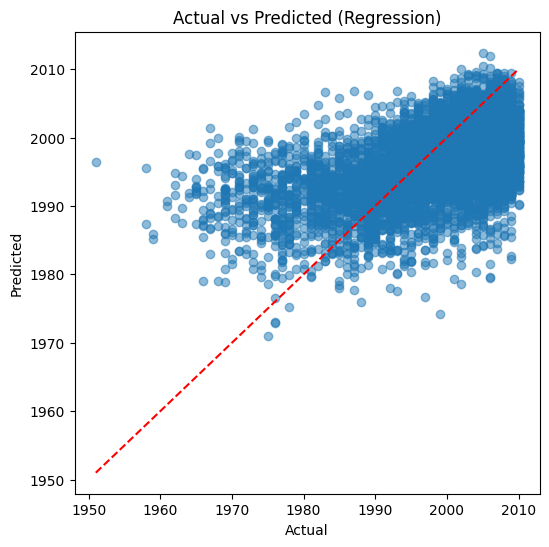

In [22]:
y_pred_reg = reg_model.predict(X_te_p).flatten()

mse  = mean_squared_error(y_te_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2   = r2_score(y_te_reg, y_pred_reg)

print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')

plt.figure(figsize=(6,6))
plt.scatter(y_te_reg, y_pred_reg, alpha=0.5)
plt.plot(
    [y_te_reg.min(), y_te_reg.max()],
    [y_te_reg.min(), y_te_reg.max()],
    'r--'
)
plt.title('Actual vs Predicted (Regression)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Klasifikasi Dengan SMOTE

In [24]:
# Transformasi untuk data klasifikasi (tambahan)
X_tr_clf_p = preprocessor.transform(X_tr_clf)
X_te_clf_p = preprocessor.transform(X_te_clf)

In [25]:
# SMOTE untuk data imbalance
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_tr_clf_p, y_tr_clf)

In [26]:
def build_clf_model(hp):
    inp = layers.Input(shape=(X_res.shape[1],))
    x = inp
    for i in range(hp.Int('num_layers', 2, 4)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        x = layers.Dense(units, activation='relu')(x)
        if hp.Boolean(f'batchnorm_{i}'):
            x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1))(x)
    out = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [30]:
tuner = kt.Hyperband(
    build_clf_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='kt_dir',
    project_name='mlp_clf'
)

stop_early = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
tuner.search(X_res, y_res, epochs=30, validation_split=0.2, callbacks=[stop_early])

best_model = tuner.get_best_models(num_models=1)[0]


Trial 90 Complete [00h 00m 39s]
val_accuracy: 0.7806680202484131

Best val_accuracy So Far: 0.7887969017028809
Total elapsed time: 00h 40m 48s


In [32]:
# Gabungkan X_res dan y_res untuk retraining model terbaik
best_model.fit(
    X_res, y_res,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
)

Epoch 1/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7890 - loss: 0.4502 - val_accuracy: 0.7801 - val_loss: 0.4818
Epoch 2/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7856 - loss: 0.4520 - val_accuracy: 0.7745 - val_loss: 0.4846
Epoch 3/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7865 - loss: 0.4549 - val_accuracy: 0.7819 - val_loss: 0.4689
Epoch 4/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7841 - loss: 0.4522 - val_accuracy: 0.7804 - val_loss: 0.4811
Epoch 5/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7867 - loss: 0.4528 - val_accuracy: 0.7773 - val_loss: 0.4790
Epoch 6/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7887 - loss: 0.4504 - val_accuracy: 0.7816 - val_loss: 0.4746
Epoch 7/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7912 - loss: 0.4471 - val_accuracy: 0.7875 - val_loss: 0.4695
Epoch 8/30
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7892 - loss: 0.4478 - val_accuracy: 0.

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      4229
           1       0.73      0.77      0.75      3797

    accuracy                           0.76      8026
   macro avg       0.75      0.76      0.75      8026
weighted avg       0.76      0.76      0.76      8026

AUC-ROC: 0.8309327851704059


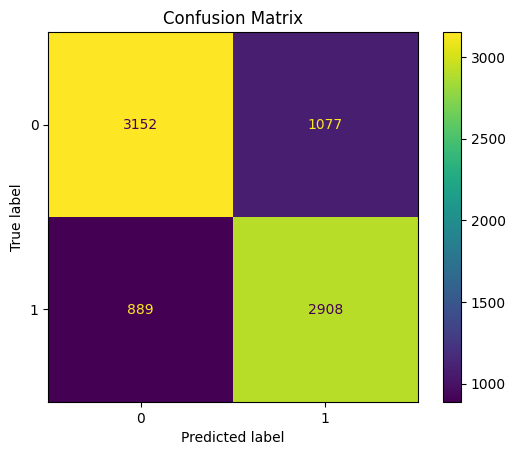

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Prediksi di test set
y_pred_proba = best_model.predict(X_te_clf_p)
y_pred = np.argmax(y_pred_proba, axis=1)

print(classification_report(y_te_clf, y_pred))
print("AUC-ROC:", roc_auc_score(y_te_clf, y_pred_proba[:, 1]))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_te_clf, y_pred)
plt.title("Confusion Matrix")
plt.show()